In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.colors as colors
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.usetex'] = True
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset, MFDataset
import numpy as np
from PIL import Image, ImageDraw

In [2]:
it = 300  # time index
dosavefig = False

#dom1 = [(1516,0), (1460,0), (1123,552), (1207,610), (1627,647), (1670,215)] # atlantis-meteor complex
dom1 = [(1516,0), (1460,0), (1123,552), (1207,610), (1530,510), (1670,215)] # atlantis-meteor complex
dom2 = [(890,1079), (1259,928), (378, 343), (157,525)] # ridge, SW portion
dom3 = [(1490,1277), (1905,1117), (1983,1004), (1850,917), (1421,1004), (1310,1099)]
dom4 = [(1260,400), (1490,400), (1490,340), (1260,340)]
dom5 = [(890,1079), (1259,928), (1421,1004), (1310,1099)]

simul = 'luckym2'

krypton = '/data0/project/vortex/lahaye/'
data_mod = krypton+'{0}_modemap/{0}_modemap.nc'.format(simul)
data_nrj = krypton+'{0}_modemap/{0}_modenrj.nc'.format(simul)
fil_grd = krypton+'lucky_corgrd.nc'
scale = 'linear'    # linear or log color-scale
picdir = "pictures/"

rho0 = 1025.

st = 2  #ncr.subsamp_step

# plotting parameters
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1450e3,1450e3 # extend in km
cmap = plt.get_cmap('seismic')  #get_colormap('WhiteBlueGreenYellowRed.ncmap')
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol='gray'   # grid color

valmax = 1e-2
valmin = -1e-2
cmap = 'seismic'

In [7]:
# load modal energy flux and plot it (at middle of time series)
imod = slice(0,10)

nc = Dataset(data_nrj,'r')
times = nc.variables['time'][:]
nt = len(times)
modes = nc.variables['mode'][:]
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
indx, indy = xi, eta
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
if isinstance(imod, int):
    fx = nc.variables['Fx_lf'][it,imod,:,:]
    fy = nc.variables['Fy_lf'][it,imod,:,:]
else:
    fx = nc.variables['Fx_lf'][it,imod,:,:].sum(axis=0)
    fy = nc.variables['Fy_lf'][it,imod,:,:].sum(axis=0)
nc.close()

ncgrd = Dataset(fil_grd,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
dx = np.mean(1./ncgrd.variables['pm'][:,xi][eta,:])*np.diff(xi[:2])[0]
dy = np.mean(1./ncgrd.variables['pn'][:,xi][eta,:])*np.diff(eta[:2])[0]
ncgrd.close()

print("loaded mode {3}, it {0}, time {1} (nt={2})".format(it, times[it],nt, modes[imod]))

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


loaded mode [0 1 2 3 4 5 6 7 8 9], it 300, time 300 (nt=720)


In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)


In [5]:
def poly_subsamp(inds, xi, eta):
    # go from coordinates in full grid to coordinate in subsampled grid
        return [(abs(xi-ii).argmin(),abs(eta-jj).argmin()) for ii,jj in inds]


<IPython.core.display.Javascript object>


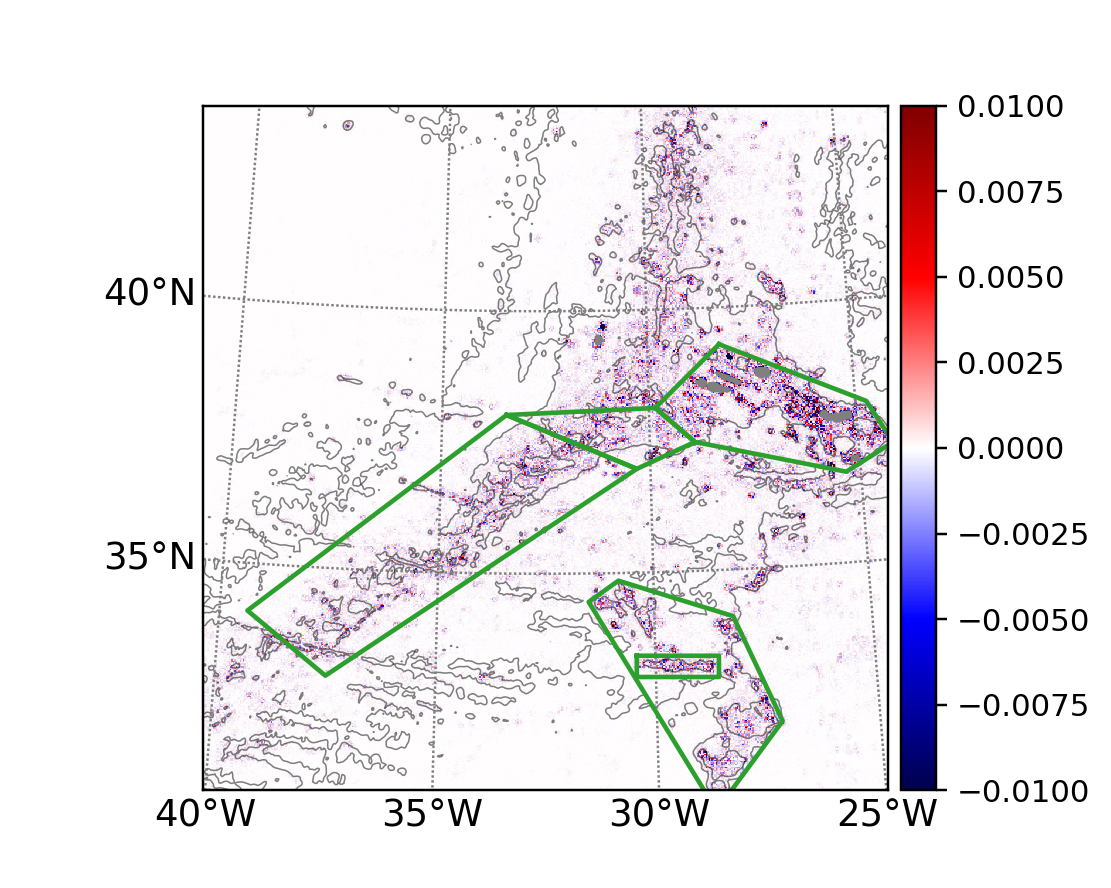

domain: integrated flux divergence: -0.287752284098 -2.95008226203
domain: integrated flux divergence: 0.314009010891 1.82787948688
domain: integrated flux divergence: -1.53367120314 -20.5641845241
domain: integrated flux divergence: -0.199264355183 -23.5624847846
domain: integrated flux divergence: -0.342779066469 -12.2716128317
total conversion is 13.23 GW 5.92075093664
6.81626033225


In [8]:
# plot data

toplot = (np.gradient(fx,dx,axis=1) + np.gradient(fy,dy,axis=0)) *1e3

#if imod == 0:
#    toplot = -toplot

doms = [dom1, dom2, dom3, dom4, dom5]

fig, axs = plt.subplots(1, 1, figsize=(5,4))

  
##### bottom-conversion term
ax, data = axs, toplot
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
    lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
for item in hct.collections:
    item.set_rasterized(True)

hpc = bm.pcolormesh(xx,yy,data,vmin=valmin,vmax=valmax,norm=norm,cmap=cmap)
hcb = bm.colorbar(hpc)

masks = []
for dom in doms:
    pola = np.r_[[np.array([lon[jj,ii],lat[jj,ii]]) for ii,jj in poly_subsamp(dom,indx,indy)]]
    x, y = bm(*pola.T.take(range(len(dom)+1),axis=1,mode='wrap'))
    bm.plot(x, y, color="tab:green")
    img = Image.new('1',topo.shape)
    ImageDraw.Draw(img).polygon(poly_subsamp(dom,indx,indy), outline=1, fill=1)
    mask = np.array(img)
    print("domain: integrated flux divergence:", np.nansum(data[mask])*dx*dy/1e6, np.nanmean(data[mask])*1e6 )
    masks.append(mask)
masktot = np.c_[masks].sum(axis=0).astype(bool)    

Ctot = np.nansum(data)*dx*dy
print('total conversion is {:.2f} GW'.format(Ctot/1e6), np.nanmean(data)*1e6)

print(np.nansum(data[50:-50,50:-50])*dx*dy/1e6)

In [32]:
np.array(dom).mean(axis=0).astype(int)

array([1220, 1027])

<IPython.core.display.Javascript object>


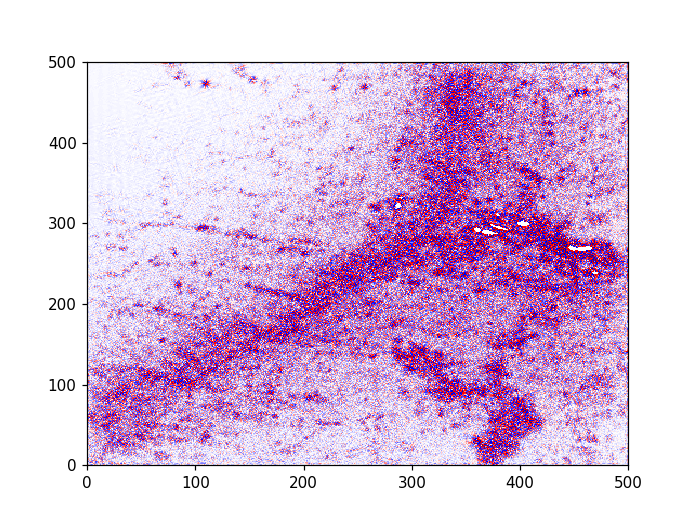